# Generates images from text prompts with VQGAN and CLIP (z+quantize method).

By jbustter https://twitter.com/jbusted1 .
Based on a notebook by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings)


In [ ]:
text_input = 'a photo-realistic and beautiful painting of an old man sitting on a chair next to a giant iceberg and looking at a green lush landscape.'  #@param {type: "string"}
output_path = "/content/output"

In [ ]:
!nvidia-smi

In [ ]:
#@title Upscale images/video frames

import os.path as osp
import glob
import cv2
import numpy as np
import torch

import requests
import imageio
import requests
import warnings
import gdown


loaded_upscale_model = False
upscale_device = None
upscale_model = None
def upscale(path):
  global loaded_upscale_model, upscale_device, upscale_model
  
  if not loaded_upscale_model:

    print("Loading superresolution model")

    !git clone https://github.com/xinntao/ESRGAN
    %cd ESRGAN
    import RRDBNet_arch as arch
    print("Downloading Super-Resolution model")
    output1 = 'RRDB_ESRGAN_x4.pth'
    print ('Downloading RRDB_ESRGAN_x4.pth')
    gdown.download('https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene', output1,quiet=False) 


    warnings.filterwarnings("ignore")

    Choose_device = "cuda" 
    model_path = 'RRDB_ESRGAN_x4.pth'

    upscale_device = torch.device(Choose_device) 


    upscale_model = arch.RRDBNet(3, 3, 64, 23, gc=32)
    upscale_model.load_state_dict(torch.load(model_path), strict=True)
    upscale_model.eval()
    upscale_model = upscale_model.to(upscale_device)

    print('Model path {:s}. \nTesting...'.format(model_path))
    
    %cd -
    loaded_upscale_model = True
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = img * 1.0 / 255
  img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
  img_LR = img.unsqueeze(0)
  img_LR = img_LR.to(upscale_device)

  print("4x upscaling", path)
  with torch.no_grad():
      output = upscale_model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
  
  output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
  output = (output * 255.0).round()
  cv2.imwrite(path, output, [int(cv2.IMWRITE_JPEG_QUALITY), 70])
  print("Done upscaling")

#import os

 
# iterate over files in
# that directory
#for file in glob.glob(f"{output_path}/*.jpg"):
#    print("upscaling", file)
#    upscale(file)

In [ ]:
!mkdir -p $output_path

!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install einops

In [ ]:
from pathlib import Path

if not Path("vqgan_imagenet_f16_16384.yaml").exists():
    !wget -N 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.yaml' -O vqgan_imagenet_f16_16384.yaml
    !wget -N 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.ckpt' -O vqgan_imagenet_f16_16384.ckpt

In [ ]:
import argparse
import math
from pathlib import Path
import sys

sys.path.append('./taming-transformers')

from IPython import display
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import numpy as np

from CLIP import clip

import kornia.augmentation as K

In [ ]:
def noise_gen(shape):
    n, c, h, w = shape
    noise = torch.zeros([n, c, 1, 1])
    for i in reversed(range(5)):
        h_cur, w_cur = h // 2**i, w // 2**i
        noise = F.interpolate(noise, (h_cur, w_cur), mode='bicubic', align_corners=False)
        noise += torch.randn([n, c, h_cur, w_cur]) / 5
    return noise


def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
    

# def replace_grad(fake, real):
#     return fake.detach() - real.detach() + real


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

replace_grad = ReplaceGrad.apply

clamp_with_grad = ClampWithGrad.apply
# clamp_with_grad = torch.clamp

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize((self.embed).unsqueeze(0), dim=2)

        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

def one_sided_clip_loss(input, target, labels=None, logit_scale=100):
    input_normed = F.normalize(input, dim=-1)
    target_normed = F.normalize(target, dim=-1)
    logits = input_normed @ target_normed.T * logit_scale
    if labels is None:
        labels = torch.arange(len(input), device=logits.device)
    return F.cross_entropy(logits, labels)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def set_cut_pow(self, cut_pow):
      self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        cutouts_full = []
        
        min_size_width = min(sideX, sideY)
        lower_bound = float(self.cut_size/min_size_width)
        
        for ii in range(self.cutn):
            
            
          size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)

          offsetx = torch.randint(0, sideX - size + 1, ())
          offsety = torch.randint(0, sideY - size + 1, ())
          cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
          cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

        
        cutouts = torch.cat(cutouts, dim=0)

        if args.use_augs:
          cutouts = augs(cutouts)

        if args.noise_fac:
          facs = cutouts.new_empty([cutouts.shape[0], 1, 1, 1]).uniform_(0, args.noise_fac)
          cutouts = cutouts + facs * torch.randn_like(cutouts)
        

        return clamp_with_grad(cutouts, 0, 1)


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

class TVLoss(nn.Module):
    def forward(self, input):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
        y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
        diff = x_diff**2 + y_diff**2 + 1e-8
        return diff.mean(dim=1).sqrt().mean()

class GaussianBlur2d(nn.Module):
    def __init__(self, sigma, window=0, mode='reflect', value=0):
        super().__init__()
        self.mode = mode
        self.value = value
        if not window:
            window = max(math.ceil((sigma * 6 + 1) / 2) * 2 - 1, 3)
        if sigma:
            kernel = torch.exp(-(torch.arange(window) - window // 2)**2 / 2 / sigma**2)
            kernel /= kernel.sum()
        else:
            kernel = torch.ones([1])
        self.register_buffer('kernel', kernel)

    def forward(self, input):
        n, c, h, w = input.shape
        input = input.view([n * c, 1, h, w])
        start_pad = (self.kernel.shape[0] - 1) // 2
        end_pad = self.kernel.shape[0] // 2
        input = F.pad(input, (start_pad, end_pad, start_pad, end_pad), self.mode, self.value)
        input = F.conv2d(input, self.kernel[None, None, None, :])
        input = F.conv2d(input, self.kernel[None, None, :, None])
        return input.view([n, c, h, w])

class EMATensor(nn.Module):
    """implmeneted by Katherine Crowson"""
    def __init__(self, tensor, decay):
        super().__init__()
        self.tensor = nn.Parameter(tensor)
        self.register_buffer('biased', torch.zeros_like(tensor))
        self.register_buffer('average', torch.zeros_like(tensor))
        self.decay = decay
        self.register_buffer('accum', torch.tensor(1.))
        self.update()
    
    @torch.no_grad()
    def update(self):
        if not self.training:
            raise RuntimeError('update() should only be called during training')

        self.accum *= self.decay
        self.biased.mul_(self.decay)
        self.biased.add_((1 - self.decay) * self.tensor)
        self.average.copy_(self.biased)
        self.average.div_(1 - self.accum)

    def forward(self):
        if self.training:
            return self.tensor
        return self.average

%mkdir /content/vids

# ARGS

In [ ]:
args = argparse.Namespace(
    
    prompts=[text_input],
    size=[384, 256], 
    init_image= None,
    init_weight= 0.5,

    # clip model settings
    clip_model='ViT-B/32',
    vqgan_config='vqgan_imagenet_f16_16384.yaml',         
    vqgan_checkpoint='vqgan_imagenet_f16_16384.ckpt',
    step_size=0.1,
    
    # cutouts / crops
    cutn=32,
    cut_pow=1,
    cut_size=100

    # display
    display_freq=5,
    seed=None,
    use_augs = True,
    noise_fac= 0.1,

    record_generation=True,

    # noise and other constraints
    use_noise = None,
    constraint_regions = False,#
    
    
    # add noise to embedding
    noise_prompt_weights = None,
    noise_prompt_seeds = [14575],#

    # mse settings
    mse_withzeros = True,
    mse_decay_rate = 50,
    mse_epoches = 5,

    # end itteration
    max_itter = 1000,
)

mse_decay = 0
if args.init_weight:
  mse_decay = args.init_weight / args.mse_epoches

# <AUGMENTATIONS>
augs = nn.Sequential(
    
    K.RandomHorizontalFlip(p=0.5),
    K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'), # padding_mode=2
    K.RandomPerspective(0.2,p=0.4, ),
    K.ColorJitter(hue=0.01, saturation=0.01, p=0.7),

    )

noise = noise_gen([1, 3, args.size[0], args.size[1]])
image = TF.to_pil_image(noise.div(5).add(0.5).clamp(0, 1)[0])
image.save('init3.png')

### Actually do the run...

Using device: cuda:0
using prompts:  ['a photo-realistic and beautiful painting of an old man sitting on a chair next to a giant iceberg and looking at a green lush landscape.']
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


0it [00:00, ?it/s]

Loading superresolution model
Cloning into 'ESRGAN'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 225 (delta 4), reused 7 (delta 2), pack-reused 216
Receiving objects: 100% (225/225), 24.86 MiB | 18.18 MiB/s, done.
Resolving deltas: 100% (84/84), done.
/content/ESRGAN


Downloading...
From: https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene
To: /content/ESRGAN/RRDB_ESRGAN_x4.pth

0.00B [00:00, ?B/s]
4.72MB [00:00, 30.3MB/s]
11.5MB [00:00, 48.4MB/s]
66.9MB [00:00, 107MB/s] 


Model path RRDB_ESRGAN_x4.pth. 
Testing...
/content
4x upscaling /content/output/progress_00000.jpg
Done upscaling
i: 0, loss: 1.00133, losses: 0.00964968, 0.991678


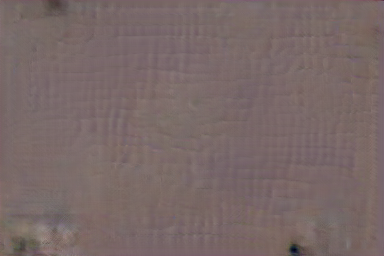

4x upscaling /content/output/progress_00005.jpg
Done upscaling
i: 5, loss: 1.02393, losses: 0.0285728, 0.995358


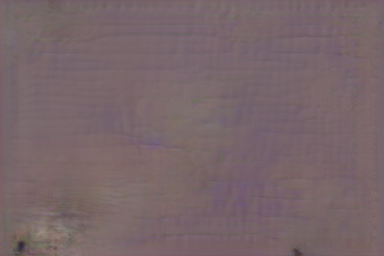

4x upscaling /content/output/progress_00010.jpg
Done upscaling
i: 10, loss: 1.03889, losses: 0.0589296, 0.979958


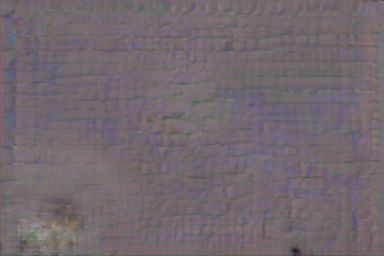

4x upscaling /content/output/progress_00015.jpg
Done upscaling
i: 15, loss: 1.06559, losses: 0.0870424, 0.978547


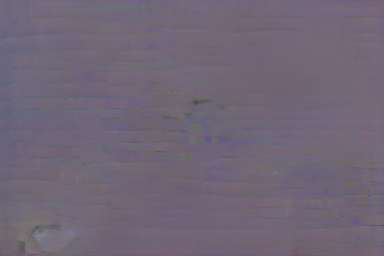

4x upscaling /content/output/progress_00020.jpg
Done upscaling
i: 20, loss: 1.06833, losses: 0.114331, 0.954


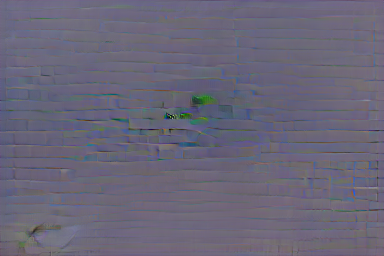

4x upscaling /content/output/progress_00025.jpg
Done upscaling
i: 25, loss: 1.0495, losses: 0.129634, 0.919867


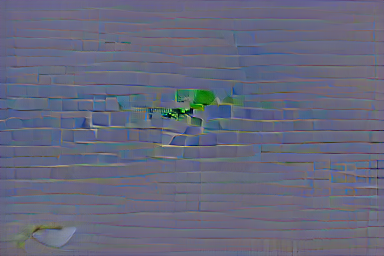

4x upscaling /content/output/progress_00030.jpg
Done upscaling
i: 30, loss: 1.05137, losses: 0.130305, 0.921069


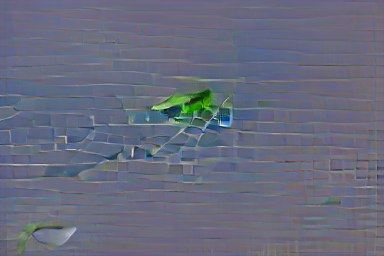

4x upscaling /content/output/progress_00035.jpg
Done upscaling
i: 35, loss: 1.03948, losses: 0.13019, 0.909289


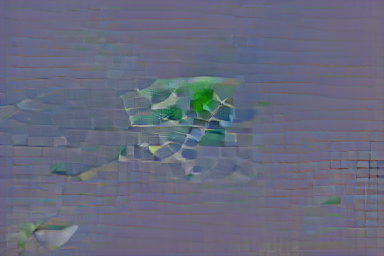

4x upscaling /content/output/progress_00040.jpg
Done upscaling
i: 40, loss: 1.03413, losses: 0.129288, 0.904842


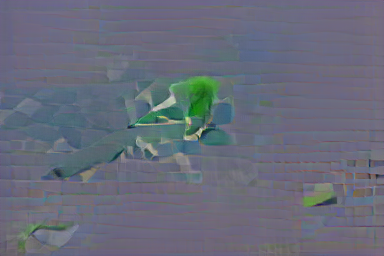

4x upscaling /content/output/progress_00045.jpg
Done upscaling
i: 45, loss: 1.00604, losses: 0.126651, 0.87939


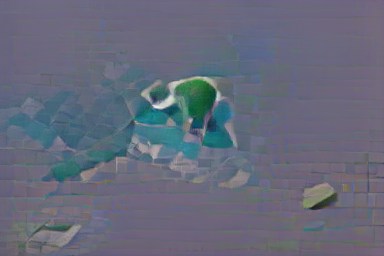

4x upscaling /content/output/progress_00050.jpg
Done upscaling
updated mse weight: 0.4
i: 50, loss: 0.987477, losses: 0.12127, 0.866207


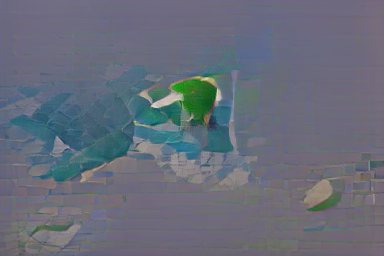

4x upscaling /content/output/progress_00055.jpg
Done upscaling
i: 55, loss: 0.936372, losses: 0.0979086, 0.838464


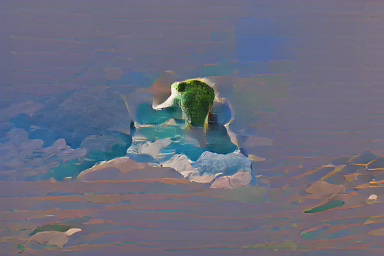

4x upscaling /content/output/progress_00060.jpg
Done upscaling
i: 60, loss: 0.94437, losses: 0.0998571, 0.844513


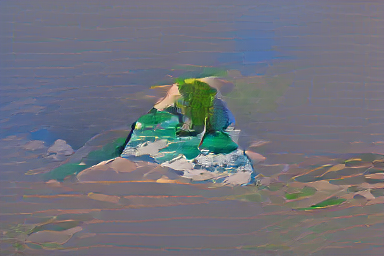

4x upscaling /content/output/progress_00065.jpg
Done upscaling
i: 65, loss: 0.946121, losses: 0.103504, 0.842617


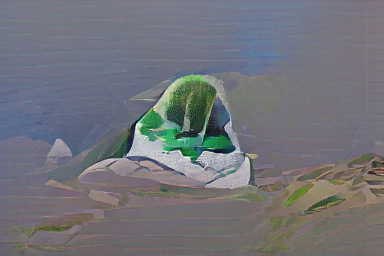

4x upscaling /content/output/progress_00070.jpg
Done upscaling
i: 70, loss: 0.935424, losses: 0.10566, 0.829764


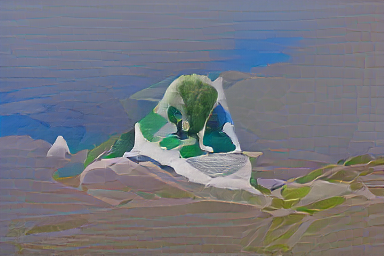

4x upscaling /content/output/progress_00075.jpg
Done upscaling
i: 75, loss: 0.906956, losses: 0.105762, 0.801194


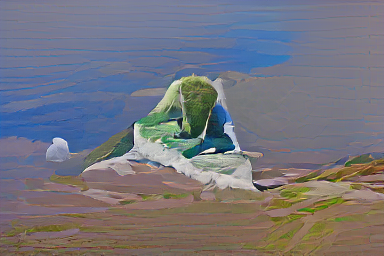

4x upscaling /content/output/progress_00080.jpg
Done upscaling
i: 80, loss: 0.907049, losses: 0.103478, 0.803571


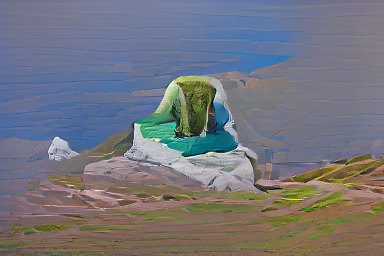

4x upscaling /content/output/progress_00085.jpg
Done upscaling
i: 85, loss: 0.893915, losses: 0.0993217, 0.794593


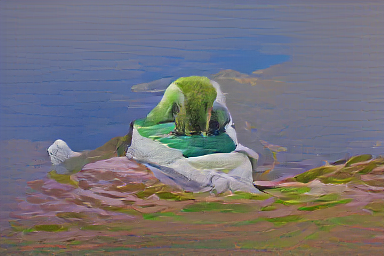

4x upscaling /content/output/progress_00090.jpg
Done upscaling
i: 90, loss: 0.910048, losses: 0.0983013, 0.811747


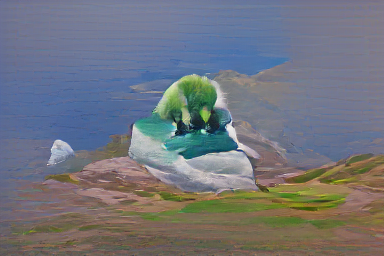

4x upscaling /content/output/progress_00095.jpg
Done upscaling
i: 95, loss: 0.8913, losses: 0.0997617, 0.791538


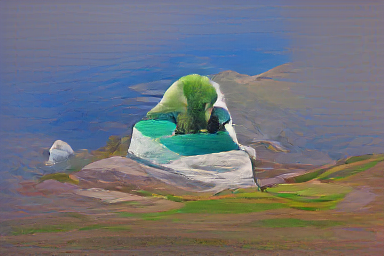

4x upscaling /content/output/progress_00100.jpg
Done upscaling
updated mse weight: 0.30000000000000004
i: 100, loss: 0.872322, losses: 0.100959, 0.771363


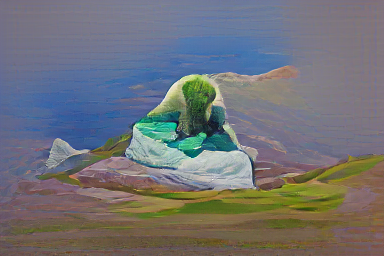

4x upscaling /content/output/progress_00105.jpg
Done upscaling
i: 105, loss: 0.859803, losses: 0.0784196, 0.781383


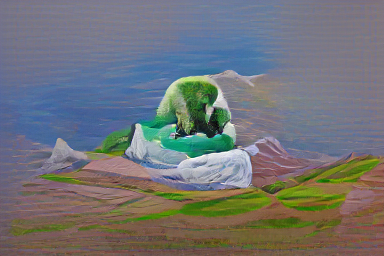

4x upscaling /content/output/progress_00110.jpg
Done upscaling
i: 110, loss: 0.860485, losses: 0.0804973, 0.779988


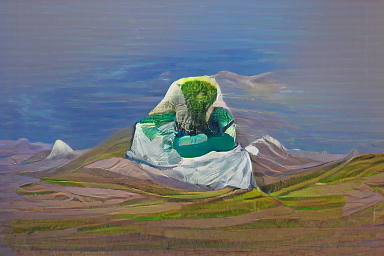

4x upscaling /content/output/progress_00115.jpg
Done upscaling
i: 115, loss: 0.851752, losses: 0.0836253, 0.768127


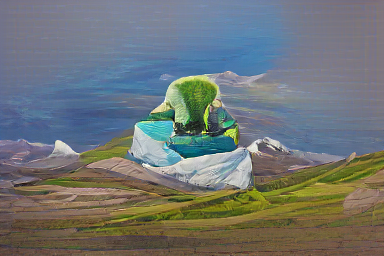

4x upscaling /content/output/progress_00120.jpg
Done upscaling
i: 120, loss: 0.870442, losses: 0.0852632, 0.785179


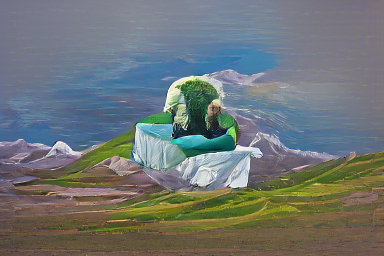

4x upscaling /content/output/progress_00125.jpg
Done upscaling
i: 125, loss: 0.883531, losses: 0.0836666, 0.799864


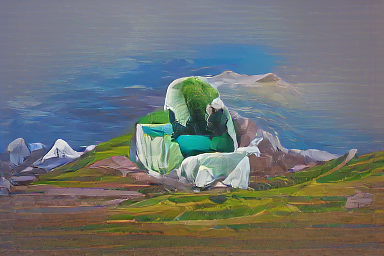

4x upscaling /content/output/progress_00130.jpg
Done upscaling
i: 130, loss: 0.851861, losses: 0.0836857, 0.768176


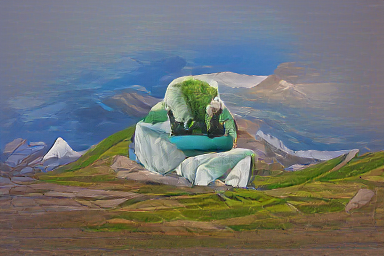

4x upscaling /content/output/progress_00135.jpg
Done upscaling
i: 135, loss: 0.844253, losses: 0.0865366, 0.757717


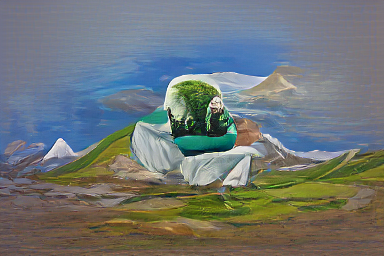

4x upscaling /content/output/progress_00140.jpg
Done upscaling
i: 140, loss: 0.834593, losses: 0.0892366, 0.745357


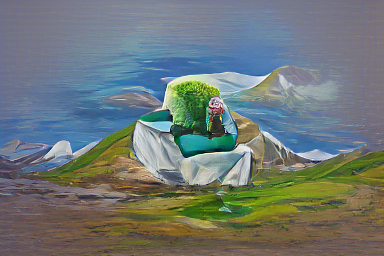

4x upscaling /content/output/progress_00145.jpg
Done upscaling
i: 145, loss: 0.828569, losses: 0.0904793, 0.73809


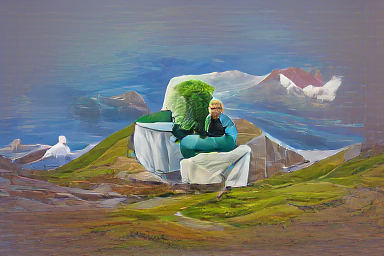

4x upscaling /content/output/progress_00150.jpg
Done upscaling
updated mse weight: 0.20000000000000004
i: 150, loss: 0.854532, losses: 0.0934813, 0.761051


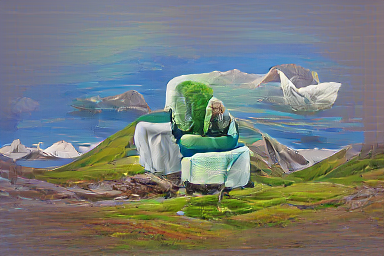

4x upscaling /content/output/progress_00155.jpg
Done upscaling
i: 155, loss: 0.798248, losses: 0.0683895, 0.729858


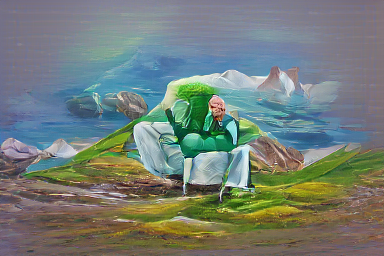

4x upscaling /content/output/progress_00160.jpg
Done upscaling
i: 160, loss: 0.817035, losses: 0.070031, 0.747004


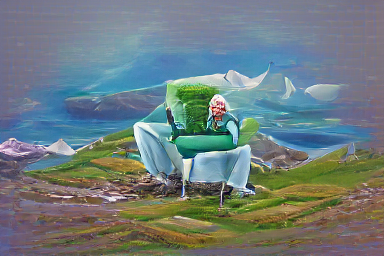

4x upscaling /content/output/progress_00165.jpg
Done upscaling
i: 165, loss: 0.793405, losses: 0.0742552, 0.71915


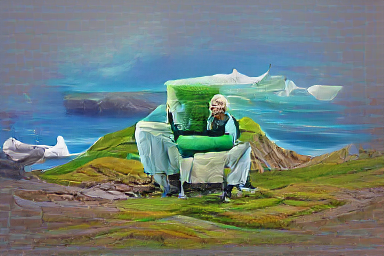

4x upscaling /content/output/progress_00170.jpg
Done upscaling
i: 170, loss: 0.799531, losses: 0.0767797, 0.722751


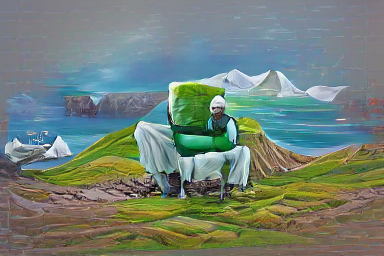

4x upscaling /content/output/progress_00175.jpg
Done upscaling
i: 175, loss: 0.824152, losses: 0.0781637, 0.745988


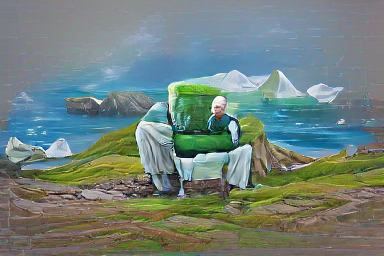

4x upscaling /content/output/progress_00180.jpg
Done upscaling
i: 180, loss: 0.787281, losses: 0.0810172, 0.706264


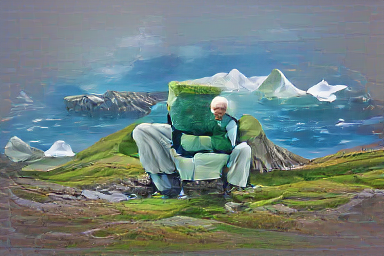

4x upscaling /content/output/progress_00185.jpg
Done upscaling
i: 185, loss: 0.832831, losses: 0.0843388, 0.748492


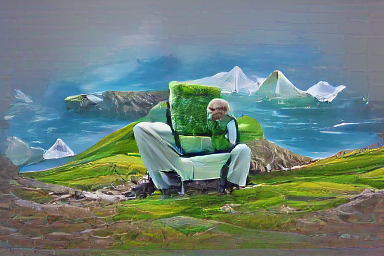

4x upscaling /content/output/progress_00190.jpg
Done upscaling
i: 190, loss: 0.792555, losses: 0.0882806, 0.704275


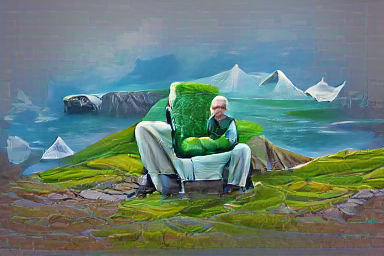

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)
print('using prompts: ', args.prompts)

tv_loss = TVLoss() 

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
mse_weight = args.init_weight

cut_size = args.cut_size
# e_dim = model.quantize.e_dim

if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
    e_dim = 256
    n_toks = model.quantize.n_embed
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]


make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

f = 2**(model.decoder.num_resolutions - 1)
toksX, toksY = args.size[0] // f, args.size[1] // f

if args.seed is not None:
    torch.manual_seed(args.seed)

if args.init_image:
    pil_image = Image.open(args.init_image).convert('RGB')
    pil_image = pil_image.resize((toksX * 16, toksY * 16), Image.LANCZOS)
    pil_image = TF.to_tensor(pil_image)
    if args.use_noise:
      pil_image = pil_image + args.use_noise * torch.randn_like(pil_image) 
    z, *_ = model.encode(pil_image.to(device).unsqueeze(0) * 2 - 1)

else:
    
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()

    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z = one_hot @ model.quantize.embed.weight
    else:
        z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)

if args.mse_withzeros and not args.init_image:
  z_orig = torch.zeros_like(z)
else:
  z_orig = z.clone()

z.requires_grad = True

opt = optim.Adam([z], lr=args.step_size, weight_decay=0.00000000)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

pMs = []

if args.noise_prompt_weights and args.noise_prompt_seeds:
  for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))


def synth(z, quantize=True):
    if args.constraint_regions:
      z = replace_grad(z, z * z_mask)

    if quantize:
      if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
      else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)

    else:
      z_q = z.model

    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z, True)

    TF.to_pil_image(out[0].cpu()).save(f'progress.png')   
    display.display(display.Image('progress.png')) 


def ascend_txt():
    global mse_weight

    out = synth(z)

    if args.record_generation:
      with torch.no_grad():
        global vid_index
        out_a = synth(z, True)
        if vid_index % 5 == 0:
          filename = f'{output_path}/progress_{vid_index:05}.jpg'
          TF.to_pil_image(out_a[0].cpu()).save(filename)
          upscale(filename)
        vid_index += 1

    cutouts = make_cutouts(out)

    iii = perceptor.encode_image(normalize(cutouts)).float()

    result = []

    if args.init_weight:
        
        global z_orig
        
        result.append(F.mse_loss(z, z_orig) * mse_weight / 2)
        # result.append(F.mse_loss(z, z_orig) * ((1/torch.tensor((i)*2 + 1))*mse_weight) / 2)

        with torch.no_grad():
          if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate*args.mse_epoches:

            if mse_weight - mse_decay > 0 and mse_weight - mse_decay >= mse_decay:
              mse_weight = mse_weight - mse_decay
              print(f"updated mse weight: {mse_weight}")
            else:
              mse_weight = 0
              print(f"updated mse weight: {mse_weight}")

    for prompt in pMs:
        result.append(prompt(iii))

    return result

vid_index = 0
def train(i):
    
    opt.zero_grad()
    lossAll = ascend_txt()

    if i % args.display_freq == 0:
        checkin(i, lossAll)
    
    loss = sum(lossAll)

    loss.backward()
    opt.step()

i = 0
try:
    with tqdm() as pbar:
        while True and i != args.max_itter:

            train(i)

            if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate * args.mse_epoches:
              
              opt = optim.Adam([z], lr=args.step_size, weight_decay=0.00000000)

            i += 1
            pbar.update()

except KeyboardInterrupt:
    pass


# create video

In [ ]:
out_file=output_path+"/video.mp4"
#!rm /content/*.mp4
last_frame=!ls -t $output_path/*.jpg | head -1
last_frame = last_frame[0]
!cp -v $last_frame $output_path/0000.jpg
!ffmpeg  -r 10 -i $output_path/%*.jpg -y -c:v libx264 -profile:v high -level:v 4.0 /tmp/vid_no_audio.mp4
!ffmpeg -i /tmp/vid_no_audio.mp4 -f lavfi -i anullsrc -c:v copy -c:a aac -shortest -y "$out_file"
#ffmpeg -i input.mp4 -f lavfi -c:v copy -c:a aac -shortest output.mp4
#!cp -v /tmp/video.mp4 "$out_file"
#!rm /content/taming-transformers/*.png
print("Written", out_file)
!sleep 2